## 0. Libraries and Personal Tools

In [1]:
import sys
from os.path import abspath

from multiprocessing import cpu_count
from gc import collect

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the default figure size and theme to display good looking matplotlib plots.
rcParams["figure.figsize"] = (10, 6)
plt.style.use("fivethirtyeight")

In [3]:
# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

from src.models.train_model import BaseModel

## 1. Build Base Model

In [4]:
base_model = BaseModel()
base_model.read_config("../models/config.yaml")
features, target = base_model.get_data()
base_model.build_base_pipeline()

In [5]:
base_model.base_pipeline

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player',
                                                 ColumnTransformer(transformers=[('demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd488787e50>),
                                                                                 ('position',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MinMaxScaler())]),
                                                                                  <sklearn.com...
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MaxAbsScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd44c695c10>)])),
                                                ('team',
                                                 ColumnTransformer(transformers=[('centroid',
                                                                                  Pipeline(steps=[('team_centroid',
                                                                                                   TeamCentroid()),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd44c695dc0>)]))]))])

In [6]:
# from pandas.core.frame import DataFrame
# DataFrame(base_model.base_pipeline.fit_transform(base_model.data)).isna().sum().sum()

## 2. Parameter Optimization

### 2.1. Split Data

In [7]:
from src.utils import create_kf_groups

from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, GroupKFold

from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper, CheckpointSaver
from skopt.space import Real, Categorical, Integer

In [8]:
from sklearn.model_selection import GroupShuffleSplit

gsp = GroupShuffleSplit(n_splits=2, test_size=0.20, random_state=777)
train_index, test_index = next(gsp.split(base_model.data, groups=base_model.data.index.get_level_values("game_num")))

X_train = base_model.data[features + [target]].iloc[train_index]

X_valid = base_model.data[features].iloc[test_index]
y_valid = base_model.data[target].iloc[test_index]

In [9]:
train_index, test_index = next(gsp.split(X_train, groups=X_train.index.get_level_values("game_num")))

X_train_cv = X_train[features].iloc[train_index]
y_train_cv = X_train[target].iloc[train_index]

X_test = X_train[features].iloc[test_index]
y_test = X_train[target].iloc[test_index]

In [10]:
del X_train

In [11]:
print(f"X_train_cv.shape: {X_train_cv.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"X_valid.shape: {X_valid.shape}")

X_train_cv.shape: (3396870, 54)
X_test.shape: (845350, 54)
X_valid.shape: (1057376, 54)


In [12]:
if base_model.config["model"]["ipca"]["batch_size"] == "auto":
    TOTAL_IPCA_BATCHES = 50
    ipca_batch = int(round(len(X_train_cv) / TOTAL_IPCA_BATCHES, -3))
else:
    ipca_batch = base_model.config["model"]["ipca"]["batch_size"]
ipca_batch

68000

In [13]:
base_model.base_pipeline.steps.append((
    "ipca", 
    IncrementalPCA(
        n_components=base_model.config["model"]["ipca"]["n_components"], 
        batch_size=ipca_batch,
        whiten=base_model.config["model"]["ipca"]["whiten"]
        ),
    ))


In [14]:
y_train_cv.value_counts()

0    3196676
1     200194
Name: team_A_scoring_within_10sec, dtype: int64

In [15]:
base_model.base_pipeline.fit(X_train_cv, y_train_cv)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player',
                                                 ColumnTransformer(transformers=[('demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd488787e50>),
                                                                                 ('position',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MinMaxScaler())]),
                                                                                  <sklearn.com...
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd44c695c10>)])),
                                                ('team',
                                                 ColumnTransformer(transformers=[('centroid',
                                                                                  Pipeline(steps=[('team_centroid',
                                                                                                   TeamCentroid()),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd44c695dc0>)]))])),
                ('ipca', IncrementalPCA(batch_size=68000, n_components=37))])

In [16]:
X_train_trans = base_model.base_pipeline.transform(X_train_cv)
X_test_trans = base_model.base_pipeline.transform(X_test)

### 2.2. Define Parameter Grid

In [17]:
if base_model.config["model"]["type"] == "xgb":
    clf = XGBClassifier(objective="binary:logistic", random_state=777)
    search_spaces = {
            "xgb__n_estimators": Integer(200, 400),
            "xgb__learning_rate": Real(0.05, 0.15, "uniform"),
            "xgb__max_depth": Integer(4, 6),
            "xgb__gamma": Real(0.05, 0.10, "uniform"),
            "xgb__subsample": Real(0.6, 0.8, "uniform"),
            "xgb__colsample_bytree": Real(0.8, 1.0, "uniform"),
        }

elif base_model.config["model"]["type"] == "lgbm":
    clf = LGBMClassifier(objective="binary", min_child_samples=None, random_state=777)


In [18]:
base_model.base_pipeline.steps.append((base_model.config["model"]["type"], clf))

### 2.3. Define K-Group-Folds

In [19]:
n_folds = 5

game_num = X_train_cv.index.get_level_values("game_num")
groups = create_kf_groups(game_num, n_folds=n_folds)

gkf = GroupKFold(n_splits=n_folds)

In [20]:
groups.value_counts()

a    689194
b    682622
c    673678
d    669740
e    681636
dtype: int64

In [21]:
base_model.base_pipeline

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player',
                                                 ColumnTransformer(transformers=[('demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd488787e50>),
                                                                                 ('position',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MinMaxScaler())]),
                                                                                  <sklearn.com...
                                                 ColumnTransformer(transformers=[('centroid',
                                                                                  Pipeline(steps=[('team_centroid',
                                                                                                   TeamCentroid()),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd44c695dc0>)]))])),
                ('ipca', IncrementalPCA(batch_size=68000, n_components=37)),
                ('lgbm',
                 LGBMClassifier(min_child_samples=None, objective='binary',
                                random_state=777))])

In [22]:
collect()

208

### 2.4. Hyperparameters - Bayesian Optimization

In [23]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize
from numpy import mean as np_mean

# -----------------------------------------------------------------------------------
#                   Guide on which params to tune/ NOT to tune
#           source: https://github.com/Microsoft/LightGBM/issues/695
# -----------------------------------------------------------------------------------
# 
# For heavily unbalanced datasets such as 1:10000:
# 
# - max_bin: keep it only for memory pressure, not to tune (otherwise overfitting)
# - learning rate: keep it only for training speed, not to tune (otherwise overfitting)
# - n_estimators: must be infinite and use early stopping to auto-tune (otherwise overfitting)
# - num_leaves: [7, 4095]
# - max_depth: [2, 63] and infinite 
# - scale_pos_weight: [1, 10000] 
# - min_child_weight: [0.01, (sample size / 1000)] 
# - subsample: [0.4, 1]
# - bagging_fraction: only 1, keep as is (otherwise overfitting)
# - colsample_bytree: [0.4, 1]
# 
# Never tune following parameters unless you have an explicit requirement to tune them:
#
# - Learning rate (lower means longer to train but more accurate, higher means smaller to train but less accurate)
# - Number of boosting iterations (automatically tuned with early stopping and learning rate)
# - Maximum number of bins (RAM dependent)

# set up hyperparameter space
space = [
    Real(0.01, 0.15, name="learning_rate"),
    Integer(500, 2500, name="n_estimators"),
    Integer(5, 80, name="max_depth"),
    Integer(30, 1500, name="num_leaves"),
    Real(0.25, 1.0, name="subsample"),
    Real(0.25, 1.0, name="colsample_bytree"),
    Integer(20, 350, name="min_data_in_leaf"),
    Real(5, 50, name="scale_pos_weight"),
    Real(0.01, 0.25, name="min_child_weight"),
    ]

from sklearn.model_selection import cross_val_score

@use_named_args(space)
def objective(**params):
    base_model.base_pipeline["lgbm"].set_params(**params)
    return -np_mean(
        cross_val_score(
            base_model.base_pipeline["lgbm"], X_train_trans, y_train_cv, 
            cv=GroupKFold(n_splits=n_folds).split(X_train_cv, y_train_cv, groups=groups), 
            n_jobs=cpu_count(), 
            scoring="neg_log_loss", 
            fit_params={
                "eval_set": [(X_test_trans, y_test)],
                "eval_metric": "neg_log_loss",
                "callbacks": [
                    early_stopping(100)
                    # log_evaluation(period=50, show_stdv=True), 
                    ],
            }
            )
        )

In [24]:
checkpoint_callback = CheckpointSaver("../models/optmization/checkpoints/lgbm.pkl", compress=9)

reg_gp = gp_minimize(
    objective, space, 
    verbose=True, 
    random_state=777, n_calls=100, 
    n_random_starts=10, 
    callback=[
        checkpoint_callback,
        DeltaYStopper(
            delta=0.0005, 
            n_best=3,
            ),
        ]
    )

Iteration No: 1 started. Evaluating function at random point.
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.274917
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.275011
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.275341
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.274906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.274623
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 523.8908
Function value obtained: 0.2745
Current minimum: 0.2745
Iteration No: 2 started. Evaluating function at random point.
Training until validation scores don't improve for 100 rounds
T

/home/ian/miniconda3/envs/kaggle-main/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.229198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.228938
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.229054
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.228686
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 438.1576
Function value obtained: 0.2282
Current minimum: 0.2196
Iteration No: 8 started. Evaluating function at random point.
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.225394
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.225499
Early stopping, best iteration is:
[1]	valid_0's bi

/home/ian/miniconda3/envs/kaggle-main/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.227913
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.227806
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.22787
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.227672
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 328.3882
Function value obtained: 0.2271
Current minimum: 0.2184
Iteration No: 24 started. Searching for the next optimal point.
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.221266
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.221025
Early stopping, best iteration is:
[1]

/home/ian/miniconda3/envs/kaggle-main/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.223992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.223785
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 357.8663
Function value obtained: 0.2231
Current minimum: 0.2184
Iteration No: 27 started. Searching for the next optimal point.
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.229859
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.230086
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.230052
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.23004
Training until validation scores don't

In [25]:
print('best score: {}'.format(reg_gp.fun))
print('best params:')
for i, param in enumerate(space):
    print(f"{param.name}: {reg_gp.x[i]} from space: [{param.low}, {param.high}]")

best score: 0.21839510169297555
best params:
learning_rate: 0.10406783475284266 from space: [0.01, 0.15]
n_estimators: 2500 from space: [500, 2500]
max_depth: 80 from space: [5, 80]
num_leaves: 1500 from space: [30, 1500]
subsample: 0.546094776086536 from space: [0.25, 1.0]
colsample_bytree: 1.0 from space: [0.25, 1.0]
min_data_in_leaf: 350 from space: [20, 350]
scale_pos_weight: 5.0 from space: [5, 50]
min_child_weight: 0.25 from space: [0.01, 0.25]


In [40]:
team = base_model.config["model"]["team"]
model = base_model.config["model"]["type"]

best_model_params = dict()
for i, param in enumerate(space):
    best_model_params[f"{param.name}"] = reg_gp.x[i]

best_model_params

{'learning_rate': 0.10406783475284266,
 'n_estimators': 2500,
 'max_depth': 80,
 'num_leaves': 1500,
 'subsample': 0.546094776086536,
 'colsample_bytree': 1.0,
 'min_data_in_leaf': 350,
 'scale_pos_weight': 5.0,
 'min_child_weight': 0.25}

### ~~2.4. Hyperparameters - Bayesian Optimization~~ (Deprecated)

In [ ]:
# Kudos to: Luca Massaron
# Source: https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-xgboost
# https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV
# https://github.com/fmfn/BayesianOptimization
# 

# NOTE: I was never able to pass fit parameters to the model with BayesSearchCV

# import warnings
# warnings.filterwarnings("ignore")
# 
# bayes_opt = BayesSearchCV(
#     estimator=base_model.base_pipeline["lgbm"],
#     search_spaces=search_spaces, 
#     n_iter=15,
#     pre_dispatch=30,
#     n_jobs=cpu_count(), 
#     iid=False,
#     verbose=2, 
#     scoring="neg_log_loss",
#     optimizer_kwargs={'base_estimator': 'GP'},
#     fit_params={
#         "early_stopping_rounds": 10, 
#         "verbose": 1,
#         # "eval_set": [(X_trans, y_test)],
#         # "eval_names": ["valid"],
#         # "eval_metric": "neg_log_loss",
#         "callbacks": [log_evaluation(period=25, show_stdv=True)],
#         },
#     cv=GroupKFold(n_splits=n_folds).split(X_train, y_train, groups=groups),
#     random_state=777,
#     )

In [ ]:
# NOTE: Maybe this was the issue. By defining a custom function to fit the optimizer 

# import pprint
# from tabnanny import verbose
# from time import time
# 
# def report_perf(optimizer, X, y, title="model", callbacks=None):
#     """
#     A wrapper for measuring time and performances of different optmizers
#     
#     optimizer = a sklearn or a skopt optimizer
#     X = the training set 
#     y = our target
#     title = a string label for the experiment
#     """
#     start = time()
#     
#     if callbacks is not None:
#         optimizer.fit(X, y, callback=callbacks)
#     else:
#         optimizer.fit(X, y)
#         
#     d=DataFrame(optimizer.cv_results_)
#     best_score = optimizer.best_score_
#     best_score_std = d.iloc[optimizer.best_index_].std_test_score
#     best_params = optimizer.best_params_
#     
#     print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
#            + u"\u00B1"+" %.3f") % (time() - start, 
#                                    len(optimizer.cv_results_['params']),
#                                    best_score,
#                                    best_score_std))    
#     print('Best parameters:')
#     pprint.pprint(best_params)
#     print()
#     return best_params

In [ ]:
# best_params = report_perf(
#     bayes_opt, 
#     X_train_trans, y_train, 
#     "LGBM", 
#     callbacks=[
#         DeltaYStopper(delta=0.01), 
#         # DeadlineStopper(120)
#         ],
#     )

## 3. Train with All Data

In [29]:
# from json import load
# with open(f"../models/team{team}/{model}_ipca_10perc/{model}_ipca_10perc.json", "r") as f:
#     best_model_params = load(f)

In [41]:
base_model = BaseModel()
base_model.read_config("../models/config.yaml")
features, target = base_model.get_data()
base_model.build_base_pipeline()

if base_model.config["model"]["type"] == "xgb":
    best_model = XGBClassifier(**best_model_params, random_state=777)
elif base_model.config["model"]["type"] == "lgbm":
    best_model = LGBMClassifier(**best_model_params, min_child_samples=None, random_state=777)

base_model.base_pipeline.steps.append((
    "ipca", 
    IncrementalPCA(
        n_components=base_model.config["model"]["ipca"]["n_components"], 
        batch_size=ipca_batch,
        whiten=base_model.config["model"]["ipca"]["whiten"]
        ),
    ))

X_test_trans = base_model.base_pipeline.fit_transform(X_test)

base_model.base_pipeline.steps.append((base_model.config["model"]["type"], best_model))

In [42]:
fit_params = {
    f"{model}__eval_set": [(X_test_trans, y_test)],
    f"{model}__eval_metric": "neg_log_loss",
    f"{model}__callbacks": [
        early_stopping(100),
        log_evaluation(period=50, show_stdv=True), 
    ],
}

fit_params.keys()

dict_keys(['lgbm__eval_set', 'lgbm__eval_metric', 'lgbm__callbacks'])

In [43]:
if base_model.config["model"]["type"] == "xgb":
    best_model = base_model.base_pipeline.fit(X_train_cv, y_train_cv)

elif base_model.config["model"]["type"] == "lgbm":
    best_model = base_model.base_pipeline.fit(
        X=X_train_cv, y=y_train_cv, **fit_params)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.296093
[100]	valid_0's binary_logloss: 0.279671
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.222529


## 4. Save Model

In [48]:
best_model_params

{'learning_rate': 0.10406783475284266,
 'n_estimators': 2500,
 'max_depth': 80,
 'num_leaves': 1500,
 'subsample': 0.546094776086536,
 'colsample_bytree': 1.0,
 'min_data_in_leaf': 350,
 'scale_pos_weight': 5.0,
 'min_child_weight': 0.25}

In [51]:
team = base_model.config["model"]["team"]
model = base_model.config["model"]["type"]

from joblib import dump
dump(best_model, f"../models/team{team}/{model}_ipca_10perc/{model}_ipca_10perc.joblib")

from json import dump, dumps
with open(f"../models/team{team}/{model}_ipca_10perc/{model}_ipca_10perc.json", "w") as f:
    dump(dumps(best_model_params, default=str), f)

## 5. Evaluate Model

In [52]:
preds = best_model.predict_proba(X_valid)[:,1]

In [53]:
from sklearn.metrics import log_loss
log_loss(y_valid, preds)

0.2162188905794332

## 4. Save Model

In [56]:
import numpy as np
import seaborn as sns
from pandas.core.frame import DataFrame, Series
from pandas import concat
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

# Kudos to: Mateus Coelho
# https://www.kaggle.com/code/mateuscco/how-to-evaluate-model-calibration/notebook

def ece(y_test, preds, strategy = 'uniform'):
    df = DataFrame({'target': y_test, 'proba': preds, 'bin': np.nan})
    
    if(strategy == 'uniform'):
        lim_inf = np.linspace(0, 0.9, 10)
        for idx, lim in enumerate(lim_inf):
            df.loc[df['proba'] >= lim, 'bin'] = idx

    elif(strategy == 'quantile'):
        pass
    
    df_bin_groups = concat([df.groupby('bin').mean(), df['bin'].value_counts()], axis = 1)
    df_bin_groups['ece'] = (df_bin_groups['target'] - df_bin_groups['proba']).abs() * (df_bin_groups['bin'] / df.shape[0])
    return df_bin_groups['ece'].sum()

def make_report(y_test, preds):
    # Computing AUC
    auc = roc_auc_score(y_test, preds)
    display(f'AUROC: {auc}')
    display(f'AUROC: {2*auc-1}')
    display(f'Fraction of positive cases in the test set: {y_test.mean()}')
    display(f'Mean predicted value in the test set:       {preds.mean()}')
    display(f'ECE (equal width bins):       {ece(y_test, preds)}')
    
    # Plotting probabilities
    display('#### Histogram of the probability distribution')
    Series(preds).hist(bins = 40)
    plt.show()
    
    # Plotting KDE by class
    display('#### KDE plots of the probability distribution by class')
    fig, ax1 = plt.subplots()
    sns.kdeplot(preds[y_test == 0], label = 'No goal', ax = ax1)
    ax2 = ax1.twinx()
    sns.kdeplot(preds[y_test == 1], label = 'Goal within 10s', color = 'red', ax = ax2)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()
    
    # Plotting calibration
    display('#### Calibration curve (equal width bins)')
    fop, mpv = calibration_curve(y_test, preds, n_bins=10)
    plt.plot(mpv, fop, "s-", label='model')
    plt.plot([0,0.25],[0,0.25], label='ideal')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.show()
    
    display('#### Calibration curve (equal size bins)')
    fop, mpv = calibration_curve(y_test, preds, n_bins=10, strategy='quantile')
    plt.plot(mpv, fop, "s-", label='model')
    plt.plot([0,0.25],[0,0.25], label='ideal')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.show()

'AUROC: 0.6792162943870902'

'AUROC: 0.3584325887741804'

'Fraction of positive cases in the test set: 0.05796708077353751'

'Mean predicted value in the test set:       0.07940199238005309'

'ECE (equal width bins):       0.024137897909694526'

'#### Histogram of the probability distribution'

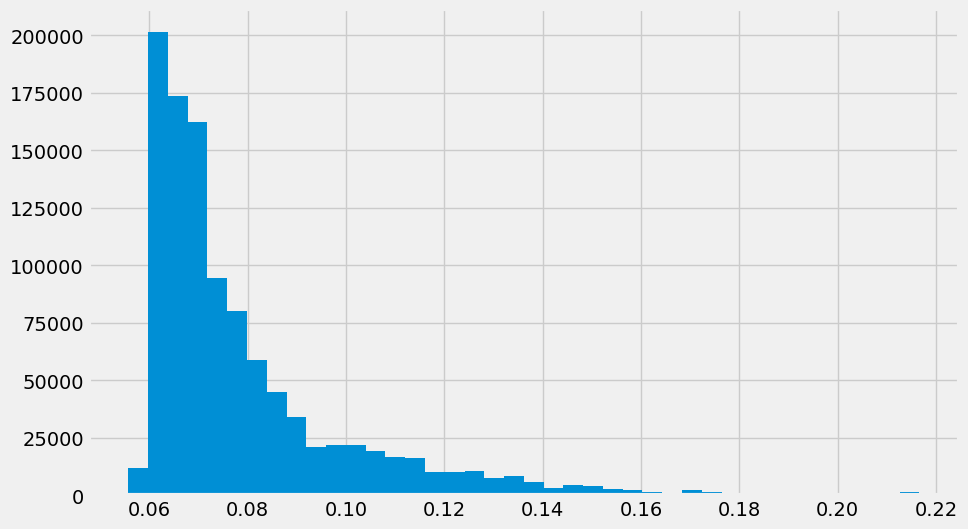

'#### KDE plots of the probability distribution by class'

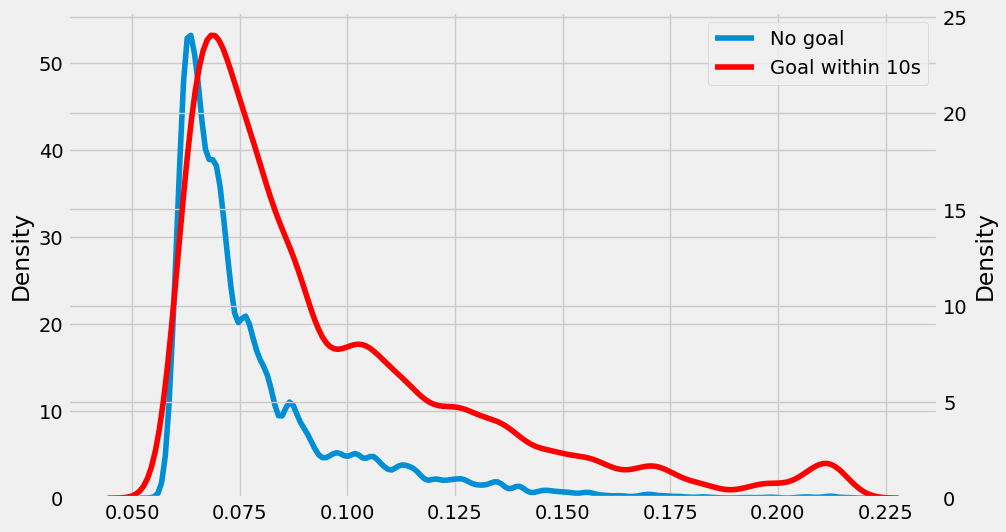

'#### Calibration curve (equal width bins)'

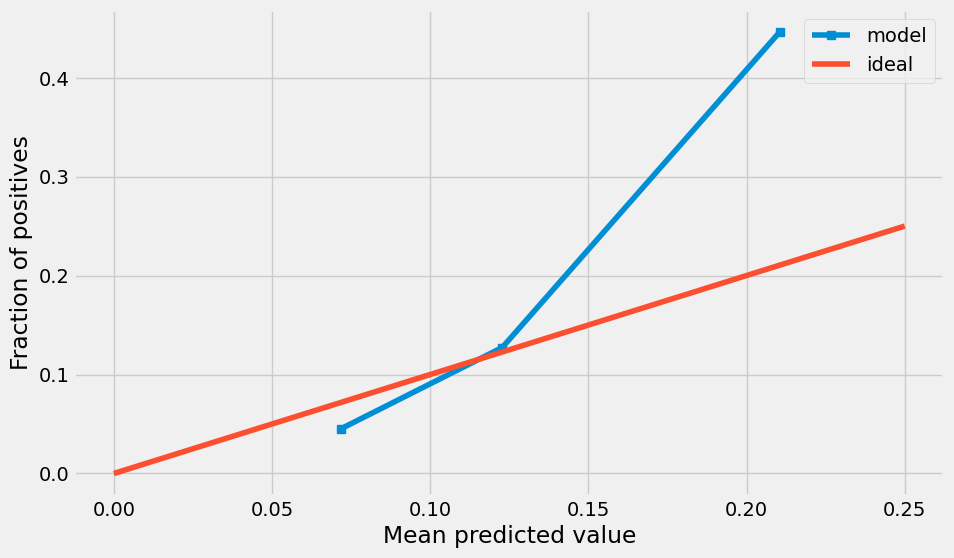

'#### Calibration curve (equal size bins)'

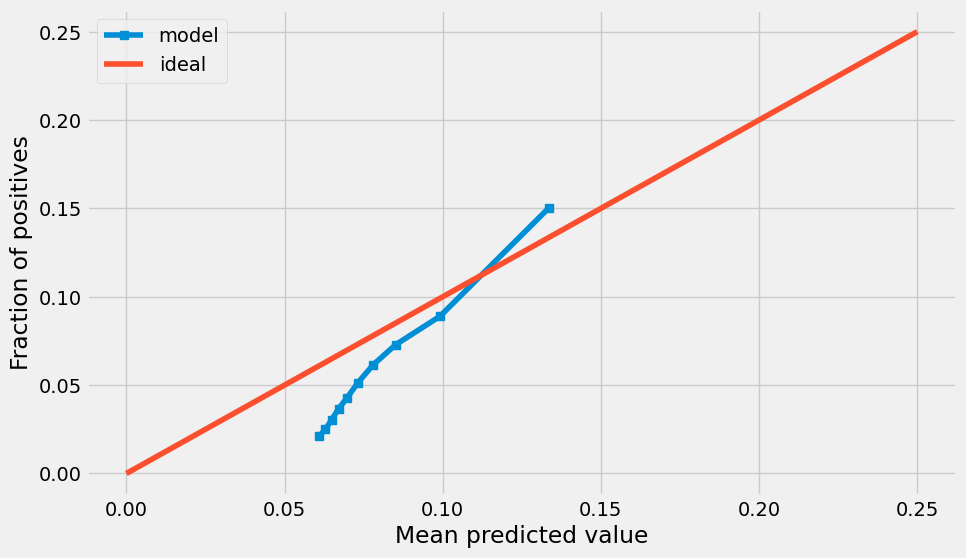

In [57]:
make_report(y_valid, preds)